# Project 3: Airbnb
**This is the third of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-12-05, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python/PySpark**
- **For each question you may use as many cells for your solution as you like**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

### Part 1: Loading, describing and preparing the data
There's quite a lot of data. Make sure that you can load and correctly parse the data, and that you understand what the dataset contains. You should also prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Par 2: Analysis
In this part your goal is to learn about trends and usage patterns from the data. You should give solutions to the tasks defined in this notebook, and you should use Spark to do the data processing. You may use other libraries like for instance Pandas and matplotlib for visualisation.

## Guidelines
- Processing data should be done using Spark. Once data has been reduced to aggregate form, you may use collect to extract it into Python for visualisation.
- Your solutions will be evaluated by correctness, code quality and interpretability of the output. This means that you have to write clean and efficient Spark code that will generate sensible execution plans, and that the tables and visualisations that you produce are meaningful and easy to read.
- You may add more cells for your solutions, but you should not modify the notebook otherwise.

### Create Spark session and define imports

In [1]:
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *
from pyspark.sql.window import Window
import math
import numpy as np
import re
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("SparkAirBnB").getOrCreate()

# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

In [2]:
listings_raw = spark.read.option('header', True)\
                         .option('inferSchema', True)\
                         .option('multiLine', True)\
                         .option('escape', '"').csv('data/listings.csv')

In [3]:
reviews_raw = spark.read.option('header', True)\
                        .option('inferSchema', True)\
                        .option('multiLine', True)\
                        .option('escape', '"').csv('data/reviews.csv')

### Describe the data
List the features (schema) and sizes of the datasets.

> The listings schema.

In [4]:
listings_raw.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

> The number of rows in listings.

In [5]:
listings_raw.count()

1330480

> The reviews schema.

In [6]:
reviews_raw.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)



> The number of rows in reviews.

In [7]:
reviews_raw.count()

32297300

### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

> We do some preliminary cleaning on the listings and reviews to get the information on the neighbourhoods. For the reviews and listings we filter out NULL data and in the reviews select interesting columns.

In [58]:
listings_raw_clean = listings_raw \
                           .filter(f.col("city").isNotNull() & \
                                   f.col("neighbourhood_cleansed").isNotNull() &\
                                   f.col("id").isNotNull() & \
                                   f.col("price").isNotNull()
                                  )

In [10]:
reviews_raw_clean = reviews_raw \
                            .filter(f.col("listing_id").isNotNull() & \
                                    f.col("id").isNotNull() & \
                                    f.col("date").isNotNull() & \
                                    f.col("comments").isNotNull() \
                                   ) \
                            .select(f.col("listing_id"), \
                                    f.col("id").alias("review_id"), \
                                    f.col("date"), \
                                    f.col("comments"))

> Stage the data. We repartition the file and store to disk so that we choose the number of partitions according to our machine and Spark doesn't have to perform the partitioning every time we perform an action, reducing the amount of time required to perform the operation.

In [11]:
reviews_raw_clean.repartition(128).write \
                        .option("header",True) \
                        .option('inferSchema', True)\
                        .option('multiLine', True)\
                        .option('escape', '"').csv('data/reviews128')

In [12]:
reviews = spark.read.option('header', True)\
                     .option('inferSchema', True)\
                     .option('multiLine', True)\
                     .option('escape', '"').csv('data/reviews128')

# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
Compute and show a dataframe with the number of listings and neighbourhoods per city.

In [13]:
listings_counts = listings_raw_clean.groupBy("city") \
                          .agg(f.count("id").alias("number_of_listings"), \
                          f.countDistinct("neighbourhood_cleansed").alias("number_of_neighbourhoods"))

In [15]:
listings_counts.orderBy(f.desc("number_of_listings")).show()

+----------------+------------------+------------------------+
|            city|number_of_listings|number_of_neighbourhoods|
+----------------+------------------+------------------------+
|           Paris|             61923|                      20|
|  Greater London|             46521|                      33|
|          London|             33100|                      33|
|         Beijing|             32338|                      17|
|     Los Angeles|             27763|                     145|
|            Roma|             25374|                      16|
|          Berlin|             24271|                     138|
|       Cape Town|             21895|                      93|
|         Toronto|             21760|                     140|
|        New York|             21457|                     120|
|       København|             20800|                      11|
|          Madrid|             20642|                     128|
|       Amsterdam|             19954|                  

Based on the table above, you should choose a city that you want to continue your analysis for. The city should have mulitple neighbourhoods with listings in them.

Compute and visualize the number of listings of different property types per neighbourhood in your city.

>We remove all ratings that have a character in them. This is done to have integer value in the colmn allowing later computations.

In [59]:
# define a UDF
def remove_characters_from_string(rating):
    # define regex to find non-digits
    non_digit_re = re.compile("\D")
    
    # search in string the regex
    if non_digit_re.search(str(rating)) != None:
        return None
    else:
        return int(rating)

# define as IntegerType so it's converted to the intended type
remove_characters_udf = f.udf(remove_characters_from_string, IntegerType())

listings_raw_clean = listings_raw_clean \
                           .withColumn("rating", remove_characters_udf(f.col("review_scores_value"))) \
                           .filter(f.col("rating").isNotNull())


> We clean the price column for the same reson as the rating column.

In [60]:
def remove_dollar_sign(price):
    price = price[1:]
    price = price.replace(",", "")
    price = re.sub("[^\.0-9]", "", price)
    return float(price)
remove_dollar_sign_udf = f.udf(remove_dollar_sign, DoubleType())



listings_correct_price = listings_raw_clean.withColumn("correct_price", remove_dollar_sign_udf(f.col("price"))) \
                                    .filter(f.col("correct_price").isNotNull())

> We now select the data useful for the analysis during the rest of the project. We stage it for quick access during the repeated querying. Smaller number of partitions this time because the size of the partitions has gone down significatly, may cause a lot of overhead if too many partitions were to be used.

In [62]:
city = "København"
listings_city = listings_correct_price.filter(f.col("city") == city)\
                    .select(f.col("id").cast(IntegerType()), 
                            f.col("rating"), 
                            f.col("correct_price"), 
                            f.col("neighbourhood_cleansed"), 
                            f.col("property_type"))

listings_city.repartition(32).write \
                        .option("header",True) \
                        .option('inferSchema', True)\
                        .option('multiLine', True)\
                        .option('escape', '"').csv('data/listings_city')

In [63]:
listings = spark.read.option('header', True)\
                     .option('inferSchema', True)\
                     .option('multiLine', True)\
                     .option('escape', '"').csv('data/listings_city')

In [64]:
property_type_count = listings.groupBy("property_type", "neighbourhood_cleansed") \
                                      .agg(f.count("id").alias("count_listings"))

property_type_neighborhood_counts = property_type_count.orderBy(f.desc("count_listings")).collect()

In [65]:
# prepare data for better display
neighborhood_properties = {}

for row in property_type_neighborhood_counts:
    property_type = row["property_type"]
    neighbourhood = row["neighbourhood_cleansed"]
    number_of_listings = row["count_listings"]
    if neighbourhood not in neighborhood_properties.keys():
        neighborhood_properties[neighbourhood] = {}
    if property_type not in neighborhood_properties[neighbourhood].keys():
        neighborhood_properties[neighbourhood][property_type] = number_of_listings
df = pd.DataFrame(neighborhood_properties)

df.head(11)

,Nrrebro,Vesterbro-Kongens Enghave,Indre By,sterbro,Amager Vest,Amager st,Bispebjerg,Valby,Vanlse,Brnshj-Husum,Frederiksberg
Apartment,3497.0,2700.0,2228.0,1823.0,1293.0,1178.0,899.0,616.0,338.0,152.0,29.0
Condominium,204.0,212.0,184.0,141.0,110.0,118.0,69.0,40.0,34.0,21.0,6.0
Loft,36.0,25.0,43.0,16.0,14.0,11.0,2.0,3.0,2.0,1.0,NaN
Townhouse,5.0,23.0,73.0,39.0,107.0,40.0,2.0,26.0,22.0,16.0,2.0
Serviced apartment,5.0,2.0,19.0,1.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
House,3.0,25.0,24.0,13.0,160.0,117.0,32.0,114.0,100.0,145.0,NaN
Guest suite,2.0,2.0,2.0,NaN,2.0,3.0,1.0,1.0,2.0,NaN,NaN
Bed and breakfast,1.0,4.0,4.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
Tiny house,1.0,NaN,1.0,1.0,3.0,3.0,NaN,NaN,NaN,1.0,NaN
Boat,NaN,3.0,6.0,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN


## Prices
Compute the minimum, maximum and average listing price in your city. 

In [68]:
stats_prices = listings.agg(f.max("correct_price").alias("max"), f.min("correct_price").alias("min"), f.avg("correct_price").alias("avg")).collect()

In [69]:
stats_prices

[Row(max=59999.0, min=0.0, avg=804.0800161067648)]

Compute and visualize the distribution of listing prices in your city.

In [71]:
min_price = float(stats_prices[0]["min"])
max_price = float(stats_prices[0]["max"])
avg_price = float(stats_prices[0]["avg"])

# define the lower bounds and upper bounds of the buckets
buckets = list(range(math.floor(min_price), math.ceil(max_price)+1, 100))
# function used to put the prices in different buckets
def bucket_prices(price):
    for bucket in range(len(buckets)-1):
        # find where the data fits
        if price < buckets[bucket+1] and price >= buckets[bucket]:
            return bucket
    # if some data goes beyond, put it in the last bucket
    return len(buckets)-1

bucket_prices_udf = f.udf(bucket_prices, IntegerType())

> We use a UDF to bin dates.

In [73]:
# add the column where the computed bucket is put in, then group by bucket and find the frequency
bins_frequency = listings.withColumn("bucket", bucket_prices_udf("correct_price")) \
                          .groupBy("bucket") \
                          .agg(f.count("bucket").alias("frequency")).collect()

In [74]:
# for plotting purposes
binned_values = [0]*((math.ceil(max_price)-math.floor(min_price)+2)//100)
for row in bins_frequency:
    binned_values[row["bucket"]] = row["frequency"]

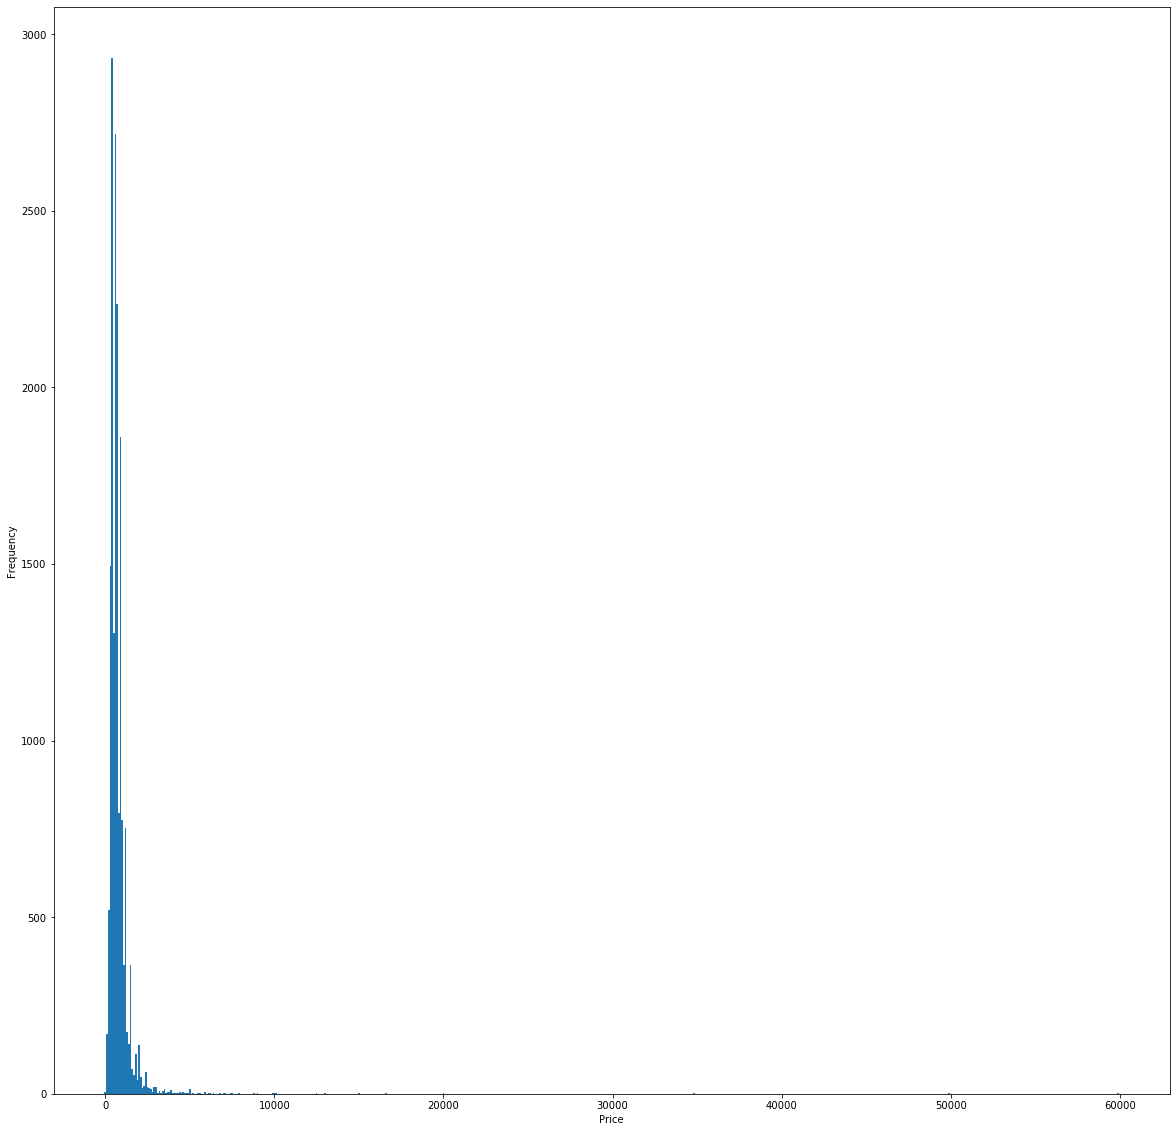

In [77]:
# create the histogram
plt.figure(figsize = (20,20))
plt.bar(buckets, binned_values, width=100)
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

The value of a listing is its rating divided by its price.

Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

In [90]:
# add a column with the value of a listing
listings_in_city = listings.withColumn("value", (f.col("rating") / f.col("correct_price")))

# window by nieghbourhood and order by the value
window = Window.partitionBy('neighbourhood_cleansed').orderBy(listings_in_city['value'].desc())

# select only the interesting columns and only the top 3 valued listings
listings_in_city.select(f.col("neighbourhood_cleansed"), \
                        f.col("property_type"), \
                        f.col("rating"), \
                        f.col("correct_price").alias("price"), \
                        f.col("value"), \
                        f.rank().over(window).alias('rank')) \
                 .filter(f.col('rank') <= 3)\
                 .show()

+----------------------+-------------+------+-----+--------------------+----+
|neighbourhood_cleansed|property_type|rating|price|               value|rank|
+----------------------+-------------+------+-----+--------------------+----+
|              Indre By|    Apartment|     9|157.0| 0.05732484076433121|   1|
|              Indre By|    Apartment|     8|143.0|0.055944055944055944|   2|
|              Indre By|         Tent|     6|109.0| 0.05504587155963303|   3|
|             Amager st|    Apartment|    10| 68.0| 0.14705882352941177|   1|
|             Amager st|    Apartment|    10|137.0|   0.072992700729927|   2|
|             Amager st|    Apartment|    10|157.0| 0.06369426751592357|   3|
|                 Valby|    Apartment|    10|102.0| 0.09803921568627451|   1|
|                 Valby|    Apartment|    10|123.0| 0.08130081300813008|   2|
|                 Valby|    Apartment|    10|143.0| 0.06993006993006994|   3|
|               sterbro|    Apartment|     9|109.0| 0.0825688073

## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

Compute and visualize the popularity (i.e., number of reviews) of your city over time.

> We group by day to analyze the overall trend.

In [91]:
# select interesting columns and convert date to correct format
reviews_date = reviews.select(
    f.col("listing_id"),
    f.col("review_id"), 
    f.to_timestamp('date', 'yyy-MM-dd').alias("date").cast(TimestampType())
)

# join with the listings, broadcast the listings, group by date and count the occurrencies, then order by date
trend_city_df = reviews_date \
                       .join(f.broadcast(listings), (f.col("listing_id") == f.col("id")), 'inner') \
                       .groupBy("date") \
                       .agg(f.count("id").alias("popularity")) \
                       .orderBy("date")

In [92]:
# get it to python
trend_city = trend_city_df.collect()

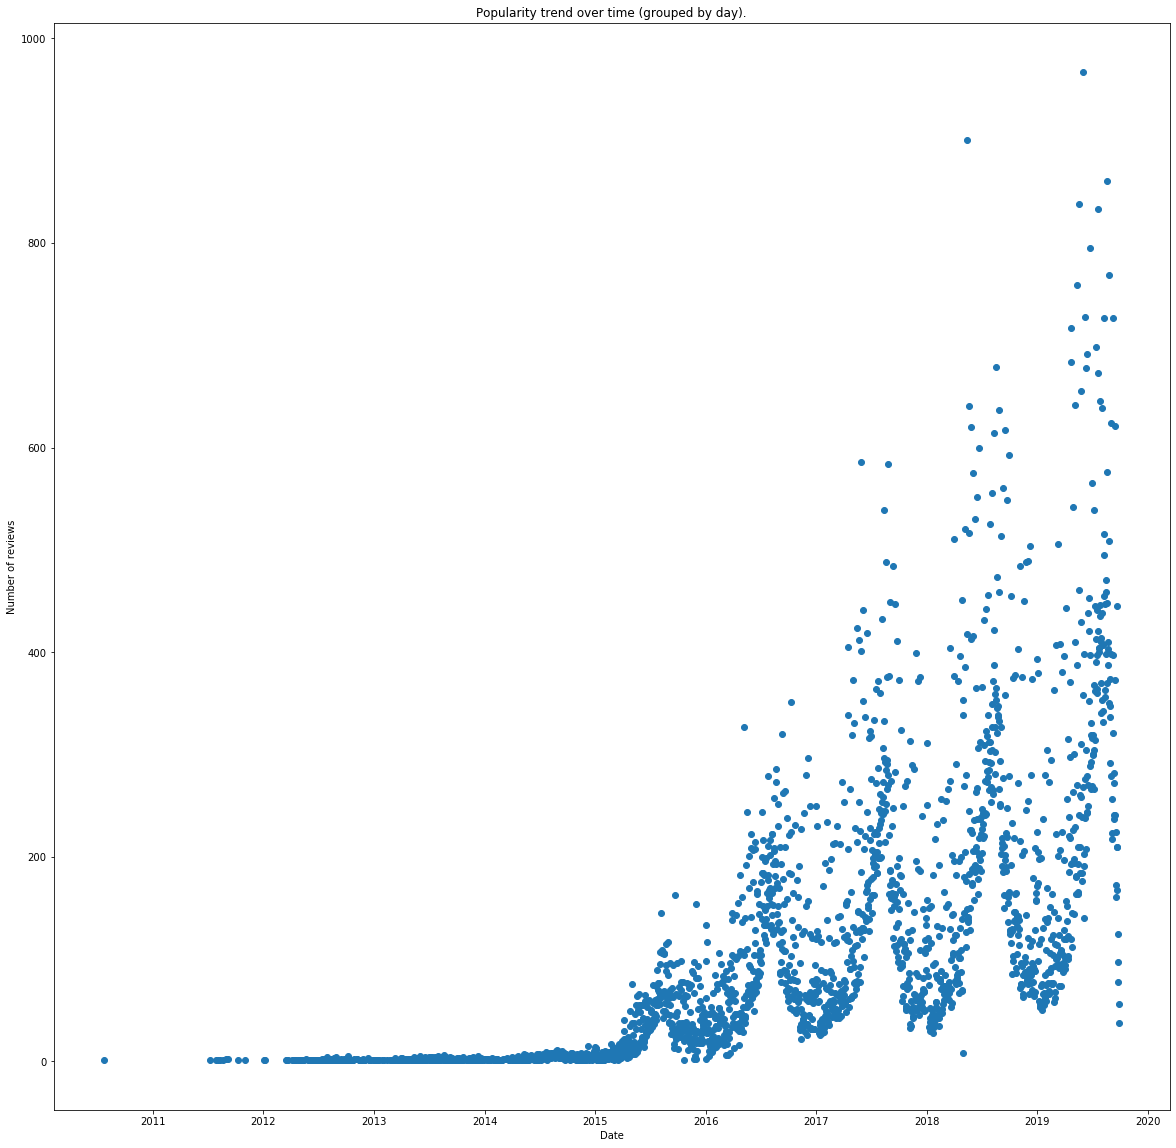

In [94]:
# plot the information gathered
q = 0
dates = [i["date"] for i in trend_city]
counts = [i["popularity"] for i in trend_city]

dates = matplotlib.dates.date2num(dates)
plt.figure(figsize = (20,20))
plt.title("Popularity trend over time (grouped by day).")
matplotlib.pyplot.plot_date(dates, counts)
plt.xlabel("Date")
plt.ylabel("Number of reviews")
plt.show()

> After 2015 we see a clear increase in the number of reviews. Furthermore, a clear trend is visible, where more reviews are published in the summer months, indicating more people using the service during that time period.

Compute and visualize the popularity of neighbourhoods over time. If there are many neighbourhoods in your city, you should select a few interesting ones for comparison.

In [95]:
# select only 3 neighbourhoods
linstings_in_city_in_neighborhoods = listings \
                                        .filter((f.col("neighbourhood_cleansed") == "sterbro") | \
                                                (f.col("neighbourhood_cleansed") == "Nrrebro") | \
                                                (f.col("neighbourhood_cleansed") == "Bispebjerg"))
# perform the same thing as before
trend_city_otime_df = reviews_date \
                       .join(f.broadcast(linstings_in_city_in_neighborhoods), (f.col("listing_id") == f.col("id")), 'inner') \
                       .groupBy("date", "neighbourhood_cleansed") \
                       .agg(f.count("review_id").alias("popularity")) \
                       .orderBy("date")

# get it to python
trend_city_otime = trend_city_otime_df.collect()

In [96]:
# prepare for plotting, just position stuff so that it's easy to access
neighborhoods_trends = {}
# for every row
for i in trend_city_otime:
    # add the neighbourhood to the dictionary
    if i["neighbourhood_cleansed"] not in neighborhoods_trends.keys():
        neighborhoods_trends[i["neighbourhood_cleansed"]] = []
    # add currect date and popularity value to the correct neighborhood
    neighborhoods_trends[i["neighbourhood_cleansed"]].append((i["date"],i["popularity"]))

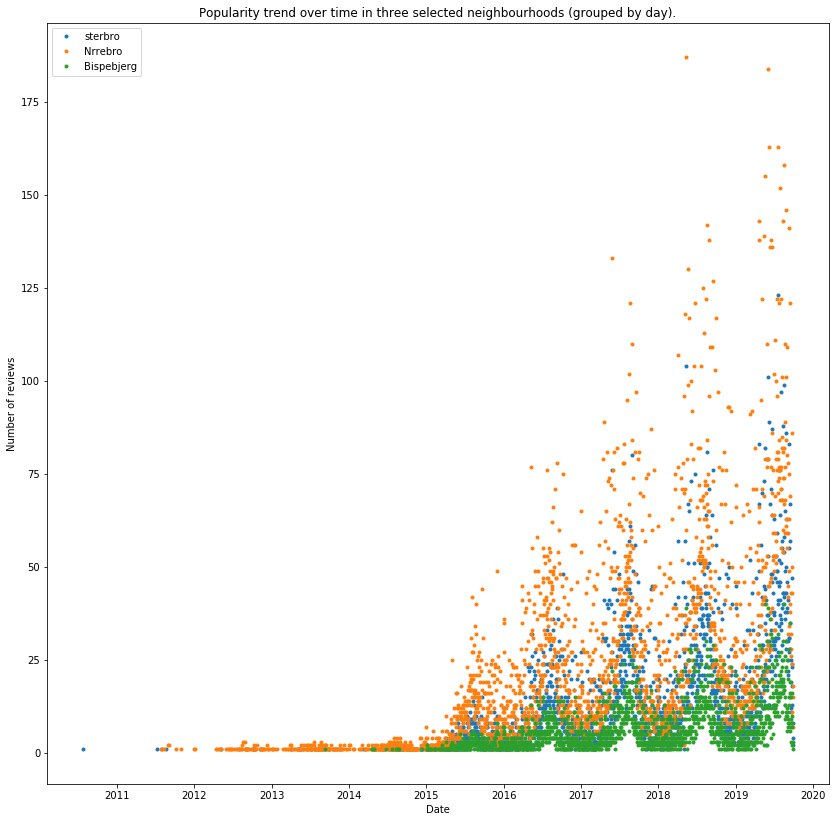

In [105]:
# plot everything
plt.figure(figsize = (14,14))

plt.title("Popularity trend over time in three selected neighbourhoods (grouped by day).")
for neigh, trends in neighborhoods_trends.items():
    dates = [i[0] for i in trends]
    counts = [i[1] for i in trends]
    dates = matplotlib.dates.date2num(dates)

    plt.plot_date(dates, counts, 'o', markersize = 3, label = neigh)
    
plt.xlabel("Date")
plt.ylabel("Number of reviews")
plt.legend()
plt.show()

Compute and visualize the popularity of your city by season. For example, visualize the popularity of your city per month.

In [106]:
# use the same 3 neighbourhoods selected before
# join with review but now select the month from the date
trend_city_month_df = reviews_date \
                       .join(f.broadcast(linstings_in_city_in_neighborhoods), (f.col("listing_id") == f.col("id")), 'inner') \
                       .groupBy(f.month("date").alias("month"), "neighbourhood_cleansed") \
                       .agg(f.count("review_id").alias("popularity")) \
                       .orderBy("month")
# bring it to python
trend_city_month = trend_city_month_df.collect()

In [107]:
# put everything nicely for plotting
neighborhoods_trends = {}
for i in trend_city_month:
    if i["neighbourhood_cleansed"] not in neighborhoods_trends.keys():
        neighborhoods_trends[i["neighbourhood_cleansed"]] = []
    neighborhoods_trends[i["neighbourhood_cleansed"]].append((i["month"],i["popularity"]))

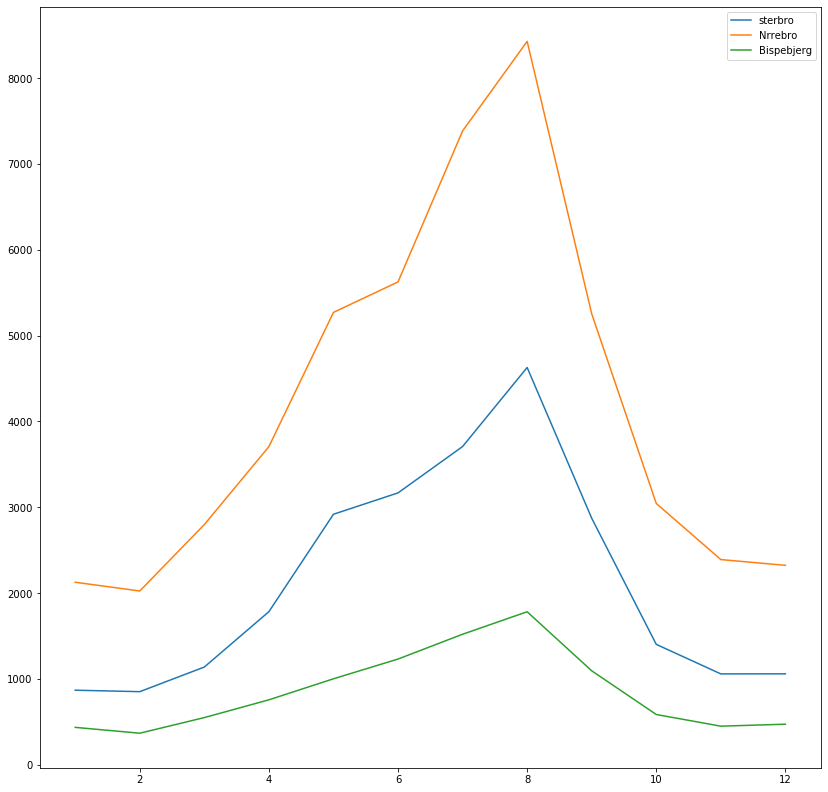

In [108]:
# plotting
plt.figure(figsize = (14,14))

for neigh, trends in neighborhoods_trends.items():
    months = [i[0] for i in trends]
    counts = [i[1] for i in trends]

    plt.plot(months, counts, label = neigh)
plt.legend()
plt.show()

> The seasonal trend here is confirmed, during august a lot of people visit Denmark.

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

> We split the comments into the words in them, languages that don't use english-like vocabulary are not reliably split.

In [165]:
from pyspark.sql.types import *
# very rudimentary function to remove punctuation and split in words
def split_text(text):
    import string
    if text == None:
        return []
    lowercase = text.lower()
    
    # keep the apostrophe information
    apostrophe = lowercase.replace('\'',' ')
    # remove punctuation
    no_punctuation = apostrophe.translate(str.maketrans('', '', string.punctuation))
    # remove newlines, carriage returns and tabs
    no_punctuation = no_punctuation.replace('\n', ' ').replace('\t', ' ').replace('\r',' ')
    
    # split into iterable
    words = no_punctuation.split(' ')
    # the filter removes empty strings
    return list(filter(None, words))

In [166]:
# define as a arraytype output
split_text_udf = f.udf(split_text,  ArrayType(StringType()))

In [167]:
# apply the splitting of the text
split_text_reviews = reviews.select(f.col("listing_id"), f.col("review_id"), f.col("comments")) \
                            .withColumn("split_text", split_text_udf(f.col("comments")))

In [168]:
# this is the results
split_text_reviews.show()

+----------+---------+------------------------------------+------------------------------------+
|listing_id|review_id|                            comments|                          split_text|
+----------+---------+------------------------------------+------------------------------------+
|  13008740|146981085|                Very good locatio...|                [very, good, loca...|
|  25176670|326512397|                very good place, ...|                [very, good, plac...|
|  33741105|486180979|                Cozy flat in a ni...|                [cozy, flat, in, ...|
|  10988509| 81074541|                Canelle's apt was...|                [canelle, s, apt,...|
|  28283000|526974366|                Si vous voulez pa...|                [si, vous, voulez...|
|  20086808|524093720|                A great place to ...|                [a, great, place,...|
|  26250574|523839025|                A absolute gem of...|                [a, absolute, gem...|
|  13560092|153333170|        

> Get the rating from the listing dataframe.

In [169]:
# get the rating associated with each review
listings_scores = listings.select(f.col("id"), f.col("rating"))
split_text_score_reviews = split_text_reviews.join(listings_scores, (f.col("listing_id") == f.col("id")), 'inner') \
                                             .select(f.col("listing_id"), \
                                                     f.col("review_id"), \
                                                     f.col("comments"), \
                                                     f.col("split_text"), \
                                                     f.col("rating"))

In [170]:
split_text_score_reviews.show()

+----------+---------+--------------------+--------------------+------+
|listing_id|review_id|            comments|          split_text|rating|
+----------+---------+--------------------+--------------------+------+
|   3895050| 26311475|Louise's house wa...|[louise, s, house...|    10|
|   3092028|422562087|Lovely flat, good...|[lovely, flat, go...|    10|
|  10348641| 97408152|What a great loca...|[what, a, great, ...|     9|
|  26988444|329521679|A very nice place...|[a, very, nice, p...|    10|
|  14325419|157978675|No hesitation! Go...|[no, hesitation, ...|    10|
|   4722899|504886854|El apartamento cu...|[el, apartamento,...|     9|
|   8978187|148831909|- Certes bien sit...|[certes, bien, si...|     9|
|   6181515|339256993|The location of L...|[the, location, o...|     9|
|  19205875|356955104|This apartment wa...|[this, apartment,...|    10|
|  28602936|344703394|The apartment was...|[the, apartment, ...|    10|
|  15852986|116166364|This is a really ...|[this, is, a, rea...|

> Get each word in a row to be later grouped.

In [171]:
# explode the text so we get a word in each row
exploded_text_reviews = split_text_score_reviews.select(f.explode(f.col("split_text")).alias("words"), \
                                                        f.col("review_id"), \
                                                        f.col("rating"), \
                                                        f.col("listing_id"))

In [172]:
exploded_text_reviews.show()

+----------+---------+------+----------+
|     words|review_id|rating|listing_id|
+----------+---------+------+----------+
|    louise| 26311475|    10|   3895050|
|         s| 26311475|    10|   3895050|
|     house| 26311475|    10|   3895050|
|       was| 26311475|    10|   3895050|
|   perfect| 26311475|    10|   3895050|
|        it| 26311475|    10|   3895050|
|       was| 26311475|    10|   3895050|
|      open| 26311475|    10|   3895050|
|      safe| 26311475|    10|   3895050|
|       and| 26311475|    10|   3895050|
|definitely| 26311475|    10|   3895050|
|   matched| 26311475|    10|   3895050|
|       the| 26311475|    10|   3895050|
|      feel| 26311475|    10|   3895050|
|        of| 26311475|    10|   3895050|
|copenhagen| 26311475|    10|   3895050|
|      also| 26311475|    10|   3895050|
|        it| 26311475|    10|   3895050|
|        is| 26311475|    10|   3895050|
|         a| 26311475|    10|   3895050|
+----------+---------+------+----------+
only showing top

### Explanation of the sentiment score
The weight is given by:
$$
S \cdot \cfrac{R}{L}
$$

$$
S = \sum_{i = 1}^{N}\left(\cfrac{s_i-5}{N} \right) = \cfrac{1}{N}\sum_{i = 1}^{N}s_i - 5
$$
If the score was below 5 it's considered a negative score, then it accumulates all the time that the words was used in a negative context. It is averaged to reduce the effects of frequently used words. This number is then multiplied by the average number of distinct reviews the word appears in. 
This means that the weight is increased if it appeared in a lot of different reviews, but then decreased if these reviews came from different listings (we try and reduce the effect of having the word used only in one review in a lot of listings, which would mean that it is actually due to a small number of people typing that in a review with score $s_i$).

In [173]:
# function to compute the weight
def compute_weight(data):
    avg_rating = data[0]
    distinct_listings = data[1]
    distinct_reviews = data[2]
    
    return (avg_rating-5)*distinct_reviews/distinct_listings

In [174]:
compute_weight_udf = f.udf(compute_weight,  DoubleType())

In [175]:
# compute the interesting statistics
reviews_avg_tf_idf = exploded_text_reviews.groupBy("words") \
                                          .agg(f.avg("rating").alias("avg_rating"), \
                                               f.approxCountDistinct("listing_id").alias("distinct_listings"), \
                                               f.approxCountDistinct("review_id").alias("distinct_reviews"))

In [180]:
# compute the weight and select only the rows that can give interesting results
reviews_weight = reviews_avg_tf_idf \
                        .filter((f.col("distinct_reviews")<10000) & (f.col("distinct_listings")>300)) \
                        .withColumn("weight", \
                                    compute_weight_udf(f.array('avg_rating', 'distinct_listings', 'distinct_reviews')))

In [181]:
reviews_weight.orderBy(f.desc("weight")).show(1000)

+---------------+-----------------+-----------------+----------------+------------------+
|          words|       avg_rating|distinct_listings|distinct_reviews|            weight|
+---------------+-----------------+-----------------+----------------+------------------+
|           anne|9.524820007578628|              311|            2035|29.607745065667228|
|           anna|9.408787541713014|              318|            1321| 18.31449164340532|
|        balcony|9.508788159111933|             2271|            5604| 11.12604528562892|
|          hosts| 9.56163289749476|             3563|            8677|11.108978010542252|
|           boat|9.289972899728998|              359|             884|10.563610148636306|
|           view|9.465643906655142|             2035|            4722|10.362049399128049|
|      vesterbro|9.531973322871714|             1161|            2516| 9.821227287119063|
|         family| 9.48589170933653|             3919|            8553| 9.790209693788041|
|         